<a href="https://colab.research.google.com/github/shubhamksingh1/TimeSeries/blob/main/AppliedTimeSeriesAnalysisWithPython/AppliedTimeSeriesAnalysisWithPython_HOTSAP_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install statsmodels==0.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 4.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# SARIMA

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
plt.rcParams['figure.figsize'] = [10, 7.5]

# Johnson&Johnson Quarterly Earnings per Share

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Udemy_Courses/AppliedTimeSeriesAnalysisWithPython/jj.csv')
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


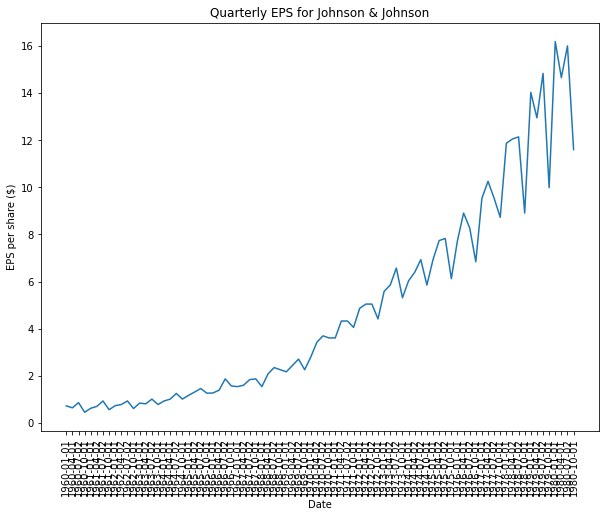

In [ ]:
plt.plot(data['date'], data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

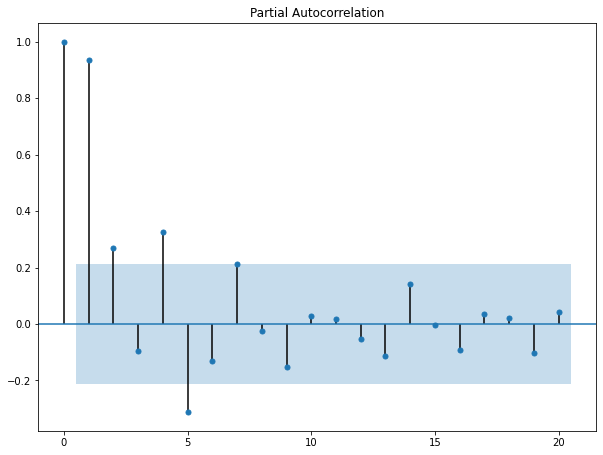

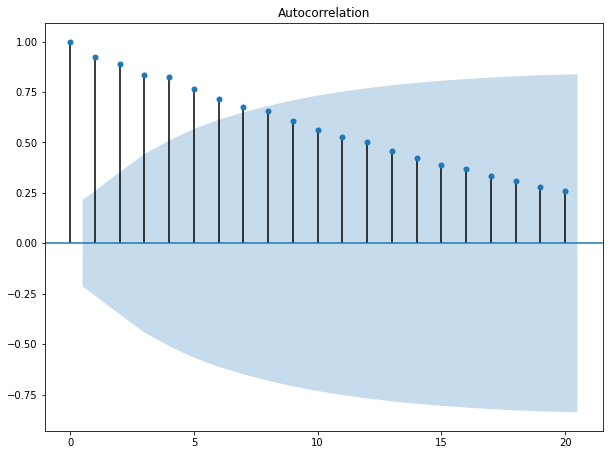

In [ ]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [ ]:
ad_fuller_result = adfuller(data['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457476
p-value: 1.0


In [ ]:
data['data_tr_1'] = np.log(data['data'])
data['data_tr_1'] = data['data_tr_1'].diff()

data.head(10)

,date,data,data_tr_1
0,1960-01-01,0.71,NaN
1,1960-04-01,0.63,-0.119545
2,1960-07-02,0.85,0.299517
3,1960-10-01,0.44,-0.658462
4,1961-01-01,0.61,0.326684
5,1961-04-02,0.69,0.123233
6,1961-07-02,0.92,0.287682
7,1961-10-01,0.55,-0.514455
8,1962-01-01,0.72,0.269333
9,1962-04-02,0.77,0.067139


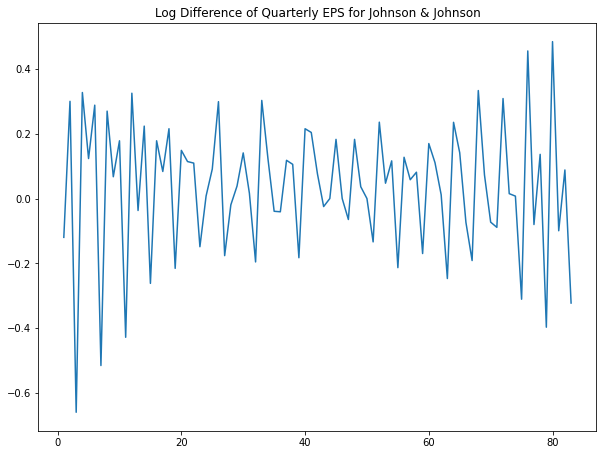

In [ ]:
plt.plot(data['data_tr_1'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [ ]:
data['data_tr_2'] = data['data_tr_1'][1:].diff(4)       #Quarterly seasonal data so 4
data.head(15)

,date,data,data_tr_1,data_tr_2
0,1960-01-01,0.71,NaN,NaN
1,1960-04-01,0.63,-0.119545,NaN
2,1960-07-02,0.85,0.299517,NaN
3,1960-10-01,0.44,-0.658462,NaN
4,1961-01-01,0.61,0.326684,NaN
5,1961-04-02,0.69,0.123233,0.242778
6,1961-07-02,0.92,0.287682,-0.011834
7,1961-10-01,0.55,-0.514455,0.144006
8,1962-01-01,0.72,0.269333,-0.057351
9,1962-04-02,0.77,0.067139,-0.056093


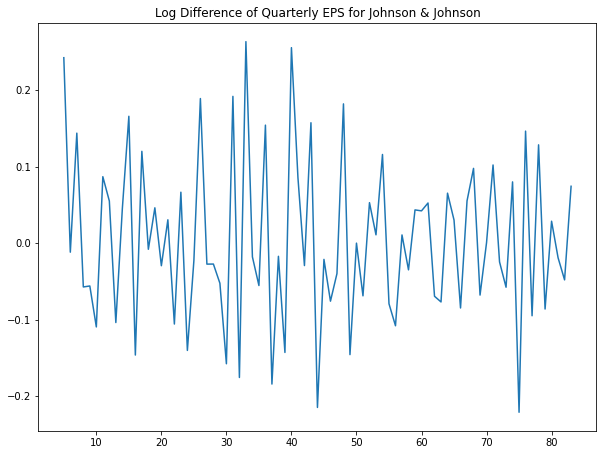

In [ ]:
plt.plot(data['data_tr_2'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

Much stable variance

In [ ]:
ad_fuller_result = adfuller(data['data_tr_2'][5:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.630805109914263
p-value: 5.72157869513621e-09


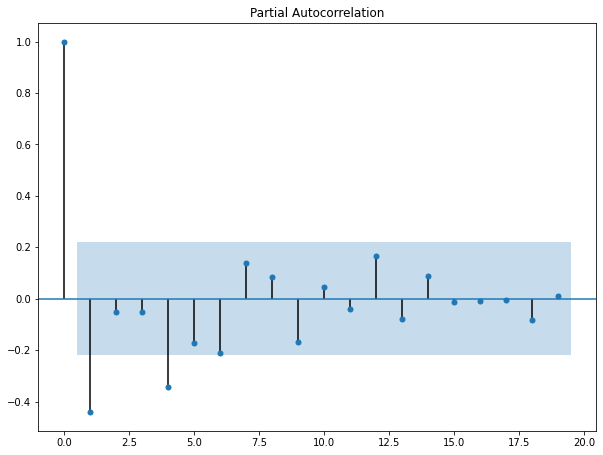

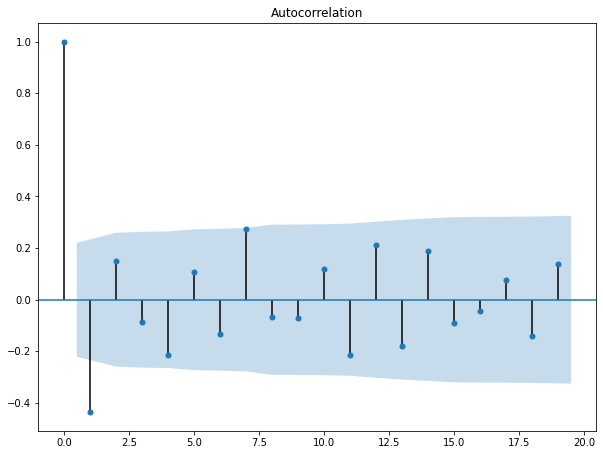

In [ ]:
plot_pacf(data['data_tr_2'][5:]);
plot_acf(data['data_tr_2'][5:]);


In [ ]:
def optimize_SARIMA(endog, parameters_list, d, D, s):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        endog - the observed variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(endog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

print(len(parameters_list))
print(parameters_list[:5])

256
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 1, 0)]


In [ ]:
result_df = optimize_SARIMA(data['data'], parameters_list, 1, 1, 4)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(2, 3, 0, 0)",92.586897
1,"(3, 2, 1, 1)",93.798955
2,"(2, 3, 1, 0)",93.976853
3,"(2, 3, 0, 1)",94.132682
4,"(3, 3, 0, 0)",94.466759
...,...,...
250,"(0, 0, 3, 1)",144.211575
251,"(0, 0, 3, 3)",145.086456
252,"(0, 0, 2, 3)",145.465206
253,"(0, 0, 3, 2)",145.563922


In [ ]:
best_model = SARIMAX(data['data'], order=(2,1,3), seasonal_order=(0,1,0,4), simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               data   No. Observations:                   84
Model:             SARIMAX(2, 1, 3)x(0, 1, [], 4)   Log Likelihood                 -40.293
Date:                            Tue, 21 Jun 2022   AIC                             92.587
Time:                                    14:14:21   BIC                            106.804
Sample:                                         0   HQIC                            98.283
                                             - 84                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4836      0.116    -12.811      0.000      -1.711      -1.257
ar.L2         -0.7895      0.131   

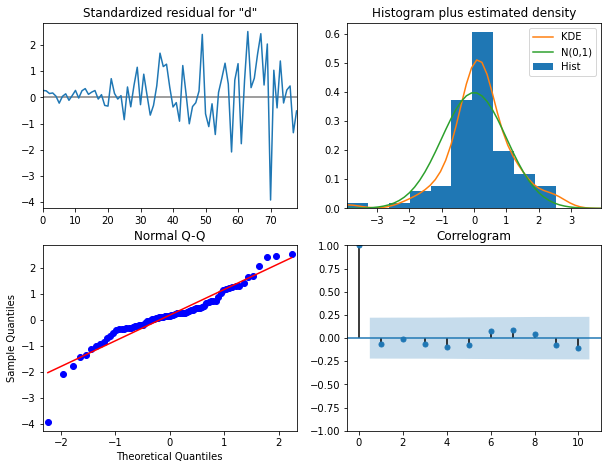

In [ ]:
res.plot_diagnostics();

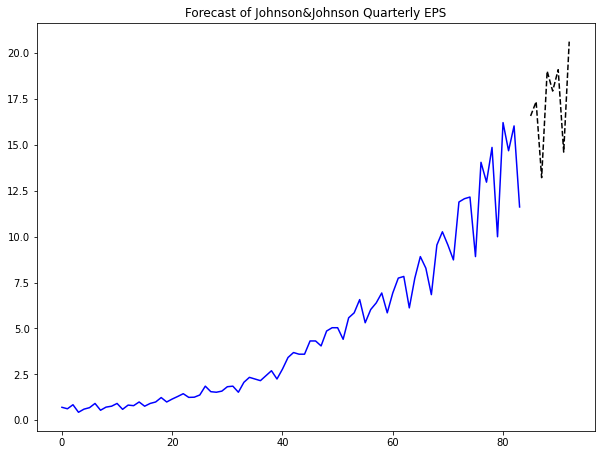

In [ ]:
n_forecast = 8
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

fig, ax = plt.subplots()
ax.plot(data['data'], 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

ax.set(title='Forecast of Johnson&Johnson Quarterly EPS')
plt.show()

In [ ]:
data['model'] = predict.predicted_mean
data.head(15)

,date,data,data_tr_1,data_tr_2,model
0,1960-01-01,0.71,NaN,NaN,0.000000
1,1960-04-01,0.63,-0.119545,NaN,0.710000
2,1960-07-02,0.85,0.299517,NaN,0.630000
3,1960-10-01,0.44,-0.658462,NaN,0.850000
4,1961-01-01,0.61,0.326684,NaN,0.795000
5,1961-04-02,0.69,0.123233,0.242778,0.530000
6,1961-07-02,0.92,0.287682,-0.011834,0.805073
7,1961-10-01,0.55,-0.514455,0.144006,0.482729
8,1962-01-01,0.72,0.269333,-0.057351,0.645237
9,1962-04-02,0.77,0.067139,-0.056093,0.748723


In [ ]:
mse = mean_squared_error(data['data'], data['model'])
print(f'MSE: {mse}')

MSE: 0.15613270550043198


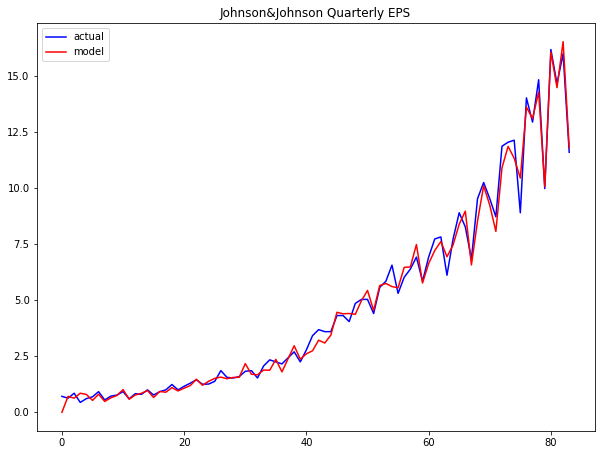

In [ ]:
plt.plot(data['data'], color='blue', label='actual')
plt.plot(data['model'], color='red', label='model')
plt.legend(loc='best')
plt.title('Johnson&Johnson Quarterly EPS')
plt.show()